In [1]:
from google.colab import drive
from google.colab import files
import pandas as pd 
import warnings
import os
import pandas as pd
import pickle
import numpy as np
import seaborn as sns
from sklearn.datasets import load_files
from keras.utils import np_utils
import matplotlib.pyplot as plt
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image                  
from tqdm import tqdm

import seaborn as sns
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score 
warnings.filterwarnings("ignore")
#mounting the drive 
drive.mount('/content/drive')
# run code in google colab since it uses libraries from the same 
# upload input files onto the local session of colab / same folder as the .py file 

Mounted at /content/drive


In [7]:
import os
def create_csv(DATA_DIR,filename):
    class_names = os.listdir(DATA_DIR)
    data = list()
    if(os.path.isdir(os.path.join(DATA_DIR,class_names[0]))):
        for class_name in class_names:
            file_names = os.listdir(os.path.join(DATA_DIR,class_name))
            for file in file_names:
                data.append({
                    "Filename":os.path.join(DATA_DIR,class_name,file),
                    "ClassName":class_name
                })
    else:
        class_name = "test"
        file_names = os.listdir(DATA_DIR)
        for file in file_names:
            data.append(({
                "FileName":os.path.join(DATA_DIR,file),
                "ClassName":class_name
            }))
    data = pd.DataFrame(data)
    data.to_csv(os.path.join('/content/drive/MyDrive/CV_project/',filename),index=False)


TRAIN_DIR = '/content/drive/MyDrive/CV_project/mediaPipe' 
create_csv(TRAIN_DIR,"train.csv")



In [8]:
data = pd.read_csv("/content/drive/MyDrive/CV_project/train.csv")

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32368 entries, 0 to 32367
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Filename   32368 non-null  object
 1   ClassName  32368 non-null  object
dtypes: object(2)
memory usage: 505.9+ KB


In [10]:
data['ClassName'].value_counts()

c0    4904
c9    3868
c1    3576
c5    3156
c4    3149
c6    3051
c3    2905
c2    2776
c7    2584
c8    2399
Name: ClassName, dtype: int64

In [11]:
data.describe()

,Filename,ClassName
count,32368,32368
unique,32368,10
top,/content/drive/MyDrive/CV_project/mediaPipe/c0...,c0
freq,1,4904


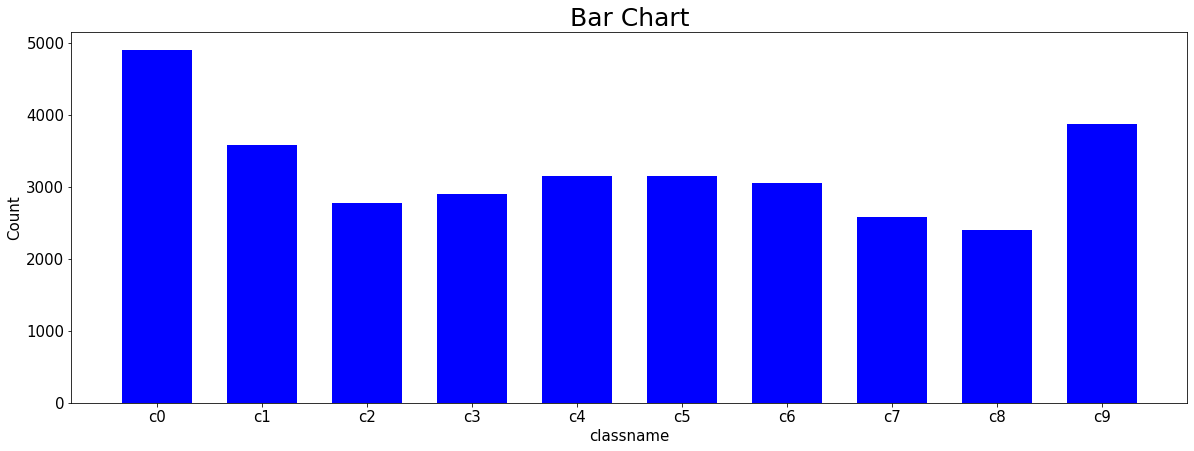

In [12]:
nf = data['ClassName'].value_counts(sort=False)
labels = data['ClassName'].value_counts(sort=False).index.tolist()
y = np.array(nf)
width = 1/1.5
N = len(y)
x = range(N)

fig = plt.figure(figsize=(20,15))
ay = fig.add_subplot(211)

plt.xticks(x, labels, size=15)
plt.yticks(size=15)

ay.bar(x, y, width, color="blue")

plt.title('Bar Chart',size=25)
plt.xlabel('classname',size=15)
plt.ylabel('Count',size=15)

plt.show()

In [13]:
del nf, labels, y, N, ay 

In [14]:
labels_list = list(set(data['ClassName'].values.tolist()))
print(labels_list)
labels_id = {'c0' : 0, 'c1' : 1, 'c2' : 2, 'c3':3, 'c4':4, 'c5' : 5, 'c6' : 6, 'c7' : 7, 'c8':8, 'c9':9}
print(labels_id)
data['ClassName'].replace(labels_id,inplace=True)

['c9', 'c8', 'c0', 'c5', 'c1', 'c7', 'c3', 'c2', 'c6', 'c4']
{'c0': 0, 'c1': 1, 'c2': 2, 'c3': 3, 'c4': 4, 'c5': 5, 'c6': 6, 'c7': 7, 'c8': 8, 'c9': 9}


In [15]:
with open(os.path.join("/content/drive/MyDrive/CV_project/", "labels_list.pkl"),"wb") as handle:
    pickle.dump(labels_id,handle)

In [16]:
from tensorflow.keras.utils import to_categorical

labels = to_categorical(data['ClassName'])
print(labels.shape)

(32368, 10)


In [17]:
from sklearn.model_selection import train_test_split

X_train, xtest, Y_train, ytest = train_test_split(data.iloc[:,0],labels,train_size = 0.7,random_state=42)

In [18]:
X_val, X_test, Y_val, Y_test = train_test_split(xtest, ytest, test_size = 0.5,random_state=42)

In [19]:
np.shape(X_train)

(22657,)

In [20]:
np.shape(X_test)

(4856,)

In [ ]:
del data

In [ ]:
del xtest, ytest

In [ ]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 


In [ ]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(128, 128))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    del img 
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [ ]:
def path_to_arr(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path,  color_mode='rgb', target_size=(128, 128))
    img = np.array(img)
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    # x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return img

def paths_to_arr(img_paths):
    list_of_tensors = [path_to_arr(img_path) for img_path in tqdm(img_paths)]
    return np.array(list_of_tensors)


In [ ]:
train = paths_to_tensor(X_train)

In [ ]:
np.shape(train)

(22657, 128, 128, 3)

In [ ]:
with open('/content/drive/MyDrive/CV_project/train.npy', 'wb') as f:
  np.save(f, train)

In [ ]:
with open('/content/drive/MyDrive/CV_project/train.npy', 'rb') as f:
  tr = np.load(f)

In [ ]:
np.shape(train)

(22657, 128, 128, 3)

In [ ]:
del train

In [ ]:
valid = paths_to_tensor(X_val)

In [ ]:
with open('/content/drive/MyDrive/CV_project/valid.npy', 'wb') as f:
  np.save(f, valid)

In [ ]:
with open('/content/drive/MyDrive/CV_project/valid.npy', 'rb') as f:
  val = np.load(f)

In [ ]:
np.shape(val)

(11328, 128, 128, 3)

In [ ]:
del val 

In [ ]:
test = paths_to_tensor(X_test)

In [ ]:
with open('/content/drive/MyDrive/CV_project/test.npy', 'wb') as f:
  np.save(f, test)

In [2]:
with open('/content/drive/MyDrive/CV_project/test.npy', 'rb') as f:
  tes = np.load(f)

In [3]:
np.shape(tes)

(4856, 128, 128, 3)

In [ ]:
del test,  tes

In [ ]:
model = Sequential()
model.add(Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=(128,128,3), kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=128, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=256, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=512, kernel_size=2, padding='same', activation='relu', kernel_initializer='glorot_normal'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(500, activation='relu', kernel_initializer='glorot_normal'))
model.add(Dropout(0.5))
model.add(Dense(10, activation='softmax', kernel_initializer='glorot_normal'))


model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      832       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       32896     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 256)       131328    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 256)      0

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
filepath = "/content/drive/MyDrive/CV_project/CNN/distracted-{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=False, mode='max',period=1)
callbacks_list = [checkpoint]

In [ ]:
model_history = model.fit(tr,Y_train,validation_data = (val, Y_val),epochs=25, batch_size=256, shuffle=True,callbacks=callbacks_list)

In [ ]:
del train

In [ ]:
del val

In [21]:
from tensorflow import keras
model = keras.models.load_model('/content/drive/MyDrive/CV_project_final/models /CNN_scratch_model.hdf5')
results = model.evaluate(tes,Y_test, batch_size=128)

38/38 [==============================] - 91s 2s/step - loss: 0.0730 - accuracy: 0.9829


In [25]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    fig.savefig("confusion_matrix.png")
    return fig

In [26]:
def print_heatmap(n_labels, n_predictions, class_names):
    labels = n_labels #sess.run(tf.argmax(n_labels, 1))
    predictions = n_predictions #sess.run(tf.argmax(n_predictions, 1))

#     confusion_matrix = sess.run(tf.contrib.metrics.confusion_matrix(labels, predictions))
    matrix = confusion_matrix(labels.argmax(axis=1),predictions.argmax(axis=1))
    row_sum = np.sum(matrix, axis = 1)
    w, h = matrix.shape

    c_m = np.zeros((w, h))

    for i in range(h):
        c_m[i] = matrix[i] * 100 / row_sum[i]

    c = c_m.astype(dtype = np.uint8)

    
    heatmap = print_confusion_matrix(c, class_names, figsize=(18,10), fontsize=20)

In [28]:
class_names = list()
for name,idx in labels_id.items():
    class_names.append(name)
ypred = model.predict(tes)

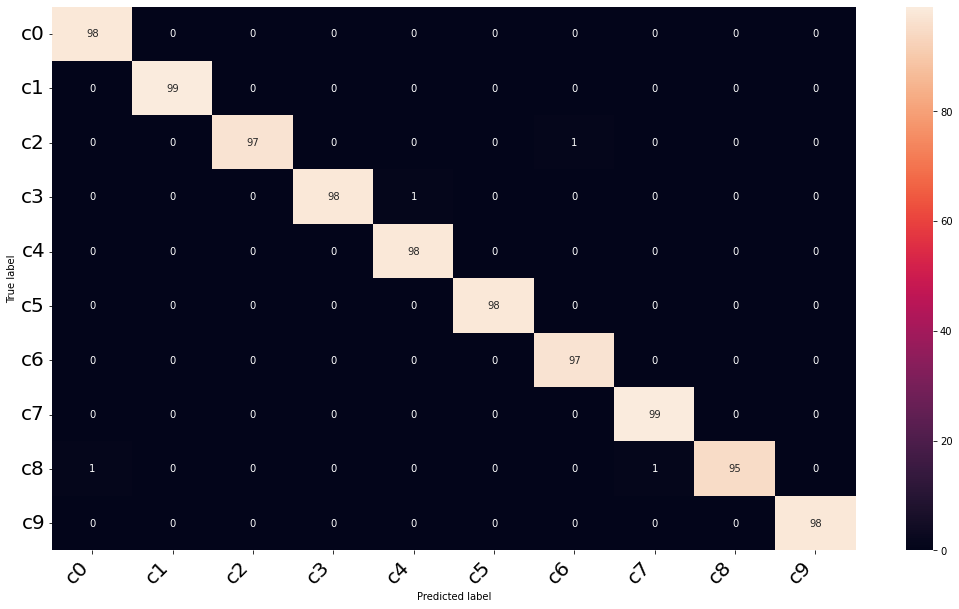

In [32]:
print_heatmap(Y_test,ypred,class_names)


In [30]:
ypred_class = np.argmax(ypred,axis=1)
ytest = np.argmax(Y_test,axis=1)

In [31]:
accuracy = accuracy_score(ytest,ypred_class)
print('Accuracy: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(ytest, ypred_class,average='weighted')
print('Precision: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(ytest,ypred_class,average='weighted')
print('Recall: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(ytest,ypred_class,average='weighted')
print('F1 score: %f' % f1)

Accuracy: 0.982908
Precision: 0.983016
Recall: 0.982908
F1 score: 0.982910
